Get Packages

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Get Data Set. Make the Required Transformation

In [4]:
train_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                        #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Data Loading

In [6]:
def dataloading(IsGBN):
  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  SEED = 1
# CUDA?
  use_cuda = torch.cuda.is_available()
  print("CUDA Available?", use_cuda)


  torch.manual_seed(SEED)

  if use_cuda:
    torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  if IsGBN == 'GBN':
    dataloader_args = dict(shuffle=True, batch_size= 128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=128)
  else:
    dataloader_args = dict(shuffle=True, batch_size= 32, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size= 32)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  return train_loader,test_loader

 


In [7]:
check_train, check_test = dataloading('BN')
dataiter = iter(check_train)
images, labels = dataiter.next()
print((images.shape))
print(len(check_train))


CUDA Available? False
torch.Size([32, 1, 28, 28])
1875


Set-up **Model**

In [8]:
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(10), nn.Dropout(dropout_value)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool1 = nn.MaxPool2d(2,2)
        
        
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels= 10, out_channels= 16, kernel_size=(3, 3), padding=1, bias=False), nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels= 20, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(20), nn.Dropout(dropout_value))
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels= 16, kernel_size=(3, 3), bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=5))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        
         

    def forward(self, x):
        x = self.convblock1(x) 
        x = self.convblock2(x) 
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x) 
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelBN = Net().to(device)
#modelGBN = Net().to(devide)
summary(modelBN, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [9]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [10]:
dropout_value = 0.0
class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),GhostBatchNorm(10,2), nn.Dropout(dropout_value)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),GhostBatchNorm(16,2), nn.Dropout(dropout_value))
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool1 = nn.MaxPool2d(2,2)
        
        
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels= 10, out_channels= 16, kernel_size=(3, 3), padding=1, bias=False), nn.ReLU(),GhostBatchNorm(16,2), nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels= 20, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),GhostBatchNorm(20,2), nn.Dropout(dropout_value))
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels= 16, kernel_size=(3, 3), bias=False),nn.ReLU(),GhostBatchNorm(16,2), nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=5))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        
         

    def forward(self, x):
        x = self.convblock1(x) 
        x = self.convblock2(x) 
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x) 
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)
  
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelGBN = NetGBN().to(device)
#modelGBN = Net().to(devide)
summary(modelGBN, input_size=(1, 28, 28))


cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
    GhostBatchNorm-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
    GhostBatchNorm-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
   GhostBatchNorm-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Set-up Train and Test Model

In [11]:
from tqdm import tqdm





misclassified=[]
lambda1 = 0.0002
lambda2 = 0.0001

def train(model, device, train_loader, optimizer, epoch, reg):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get full data of one batch
    data, target = data.to(device), target.to(device)

    # Initgrad
    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss for that batch
    loss = F.nll_loss(y_pred, target)
   
    regularization_loss1 = 0
    regularization_loss2 = 0

    #Update loss based on regularization
    if reg=="None":
      loss = loss
      train_loss += loss.item()
    elif reg=="L1":
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
      loss += (lambda1*regularization_loss1)
      train_loss += loss.item()
      
    elif reg=="L2":
      for param in model.parameters():
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda2*regularization_loss2)
      train_loss += loss.item()
      
    else:
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_loss += loss.item()
      
    # Backpropagation an optimization for that batch
    loss.backward()
    optimizer.step()


    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_loss /= len(train_loader.dataset)
  train_losses.append(train_loss)
  train_acc.append(100*correct/processed)
    



def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            if epoch == 23 :
              temp = pred.eq(target.view_as(pred)).sum().item()
              temp1 = target.view_as(pred)
              if(len(misclassified)<25):
                #print('Check missclass')
                for i in range(len(temp1)):
                  if(temp1[i]!=pred[i]):
                    misclassified.append([data[i],temp1[i],pred[i]])
                  if(len(misclassified)==25):
                    break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test_Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append((100. * correct / len(test_loader.dataset)))




Run Model

In [ ]:
from torch.optim.lr_scheduler import StepLR
import copy
torch.manual_seed(2)

model_type = {}
validation_acc = {}
validation_loss = {}
train_lossmat = {}
train_accmat = {}
missclass = {}




  
# Adding list as value 
model_type["BNL1"] = ['BN', 'L1']
model_type["BNL2"] = ['BN', 'L2']
model_type["BNL1L2"] = ['BN', 'All']
model_type["GBN"] = ['GBN', 'NRL']
model_type["GBNL1L2"] = ['GBN', 'ALL']

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


for key, value in model_type.items():
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  misclassified=[]
  
  
  
  if value[0] == 'BN':
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
    train_loader, test_loader = dataloading('BN')
  else:
    model = NetGBN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
    train_loader, test_loader = dataloading('GBN')
    
  EPOCHS = 25
  
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, value[1])
    test(model, device, test_loader, epoch)
    scheduler.step()
  validation_acc[key] = copy.deepcopy(test_acc)
  validation_loss[key] = copy.deepcopy(test_losses)

  train_lossmat[key] = copy.deepcopy(train_losses)
  train_accmat[key] = copy.deepcopy(train_accmat)
  missclass[key] = copy.deepcopy(misclassified)





  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.4120125770568848 Batch_id=1 Accuracy=6.25:   0%|          | 2/1875 [00:00<02:23, 13.06it/s]

CUDA Available? False
EPOCH: 0


Loss=0.14933860301971436 Batch_id=1874 Accuracy=91.78: 100%|██████████| 1875/1875 [02:12<00:00, 14.14it/s]
Loss=0.1845569759607315 Batch_id=1 Accuracy=98.44:   0%|          | 2/1875 [00:00<02:05, 14.91it/s]


Test set: Average loss: 0.0842, Test_Accuracy: 9738/10000 (97.38%)

EPOCH: 1


Loss=0.19622327387332916 Batch_id=1874 Accuracy=96.99: 100%|██████████| 1875/1875 [02:12<00:00, 14.10it/s]
Loss=0.24735939502716064 Batch_id=1 Accuracy=95.31:   0%|          | 2/1875 [00:00<02:06, 14.82it/s]


Test set: Average loss: 0.0456, Test_Accuracy: 9864/10000 (98.64%)

EPOCH: 2


Loss=0.28823670744895935 Batch_id=1874 Accuracy=97.51: 100%|██████████| 1875/1875 [02:13<00:00, 14.02it/s]
Loss=0.1648695319890976 Batch_id=1 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:08, 14.62it/s]


Test set: Average loss: 0.0401, Test_Accuracy: 9861/10000 (98.61%)

EPOCH: 3


Loss=0.3165070712566376 Batch_id=1874 Accuracy=97.58: 100%|██████████| 1875/1875 [02:13<00:00, 14.02it/s]
Loss=0.15134771168231964 Batch_id=1 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:16, 13.71it/s]


Test set: Average loss: 0.0509, Test_Accuracy: 9836/10000 (98.36%)

EPOCH: 4


Loss=0.15564221143722534 Batch_id=1874 Accuracy=98.50: 100%|██████████| 1875/1875 [02:14<00:00, 13.99it/s]
Loss=0.19119906425476074 Batch_id=1 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:08, 14.59it/s]


Test set: Average loss: 0.0258, Test_Accuracy: 9909/10000 (99.09%)

EPOCH: 5


Loss=0.13186272978782654 Batch_id=1874 Accuracy=98.67: 100%|██████████| 1875/1875 [02:13<00:00, 14.02it/s]
Loss=0.12230434268712997 Batch_id=1 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:19, 13.39it/s]


Test set: Average loss: 0.0233, Test_Accuracy: 9922/10000 (99.22%)

EPOCH: 6


Loss=0.19262419641017914 Batch_id=1874 Accuracy=98.69: 100%|██████████| 1875/1875 [02:14<00:00, 13.97it/s]
Loss=0.16724856197834015 Batch_id=1 Accuracy=98.44:   0%|          | 2/1875 [00:00<02:11, 14.26it/s]


Test set: Average loss: 0.0227, Test_Accuracy: 9926/10000 (99.26%)

EPOCH: 7


Loss=0.1288534551858902 Batch_id=1874 Accuracy=98.79: 100%|██████████| 1875/1875 [02:13<00:00, 14.02it/s]
Loss=0.1238546296954155 Batch_id=1 Accuracy=98.44:   0%|          | 2/1875 [00:00<02:06, 14.78it/s]


Test set: Average loss: 0.0229, Test_Accuracy: 9920/10000 (99.20%)

EPOCH: 8


Loss=0.1126122996211052 Batch_id=1874 Accuracy=98.86: 100%|██████████| 1875/1875 [02:13<00:00, 14.08it/s]
Loss=0.12111702561378479 Batch_id=1 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:14, 13.92it/s]


Test set: Average loss: 0.0220, Test_Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.11397148668766022 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [02:14<00:00, 13.95it/s]
Loss=0.12827368080615997 Batch_id=1 Accuracy=98.44:   0%|          | 2/1875 [00:00<02:09, 14.44it/s]


Test set: Average loss: 0.0220, Test_Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.14414896070957184 Batch_id=1874 Accuracy=98.86: 100%|██████████| 1875/1875 [02:13<00:00, 14.06it/s]
Loss=0.23041436076164246 Batch_id=1 Accuracy=96.88:   0%|          | 2/1875 [00:00<02:09, 14.48it/s]


Test set: Average loss: 0.0214, Test_Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.1683746725320816 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [02:14<00:00, 13.96it/s]


In [37]:
print(validation_acc['BNL1'], validation_acc['GBNL1L2'])


[97.77, 98.05] [95.91, 97.9]


In [10]:
def plot_graphs(df_array, legend_arr, xlabel="Epochs", ylabel="Accuracy"):
    fig, ax = plt.subplots(figsize=(15, 6))
    for i in range(len(df_array)):
        ax.plot(range(2),
            df_array[i])
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.legend(legend_arr)
    plt.show()

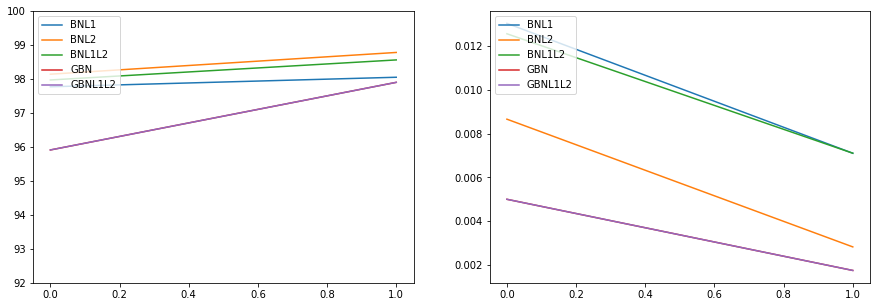

In [34]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(15,5))
axs[0].set_ylim(92, 100) 
axs[0].plot(validation_acc['BNL1'])
axs[0].plot(validation_acc['BNL2'])
axs[0].plot(validation_acc['BNL1L2'])
axs[0].plot(validation_acc['GBN'])
axs[0].plot(validation_acc['GBN'])
axs[1].plot(train_lossmat['BNL1'])
axs[1].plot(train_lossmat['BNL2'])
axs[1].plot(train_lossmat['BNL1L2'])
axs[1].plot(train_lossmat['GBN'])
axs[1].plot(train_lossmat['GBNL1L2'])
axs[0].legend(['BNL1', 'BNL2', 'BNL1L2', 'GBN', 'GBNL1L2'], loc='upper left')
axs[1].legend(['BNL1', 'BNL2', 'BNL1L2', 'GBN', 'GBNL1L2'], loc='upper left')

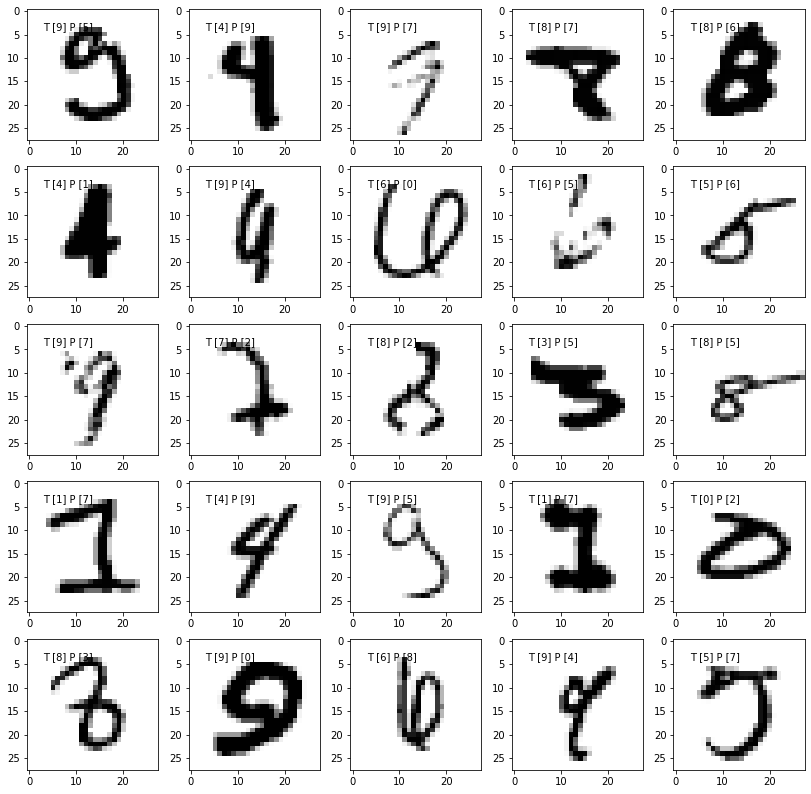

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(5):
  for j in range(5):
    data,t,p = missclass['GBN'][index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    #axs[i,j].set_title(str(t.cpu().numpy())+" "+str(p.cpu().numpy()))
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;